We consider Gaussian Mixture target 
\begin{equation}
    q_0 = \sum_{k=1}^K w_k \mathcal{N}(x; m_k, C_k)
\end{equation}
The forward process with  $\lambda_t = e^{-t}$ and $\sigma_t = \sqrt{1 - e^{-2t}}$ gives
\begin{align*}
	q_t(y) = &  \int_{R^d} \frac{1}{(\sqrt{2\pi} \sigma_t)^d} \cdot \exp \left( -\frac{\|y - \lambda_t x\|_2^2}{2\sigma_t^2} \right) q_0(x) \mathrm{d} x \\
	= & \sum_{k=1}^K w_k \mathcal{N}(y; \lambda_t m_k, \lambda_t^2 C_k + \sigma_t^2 I)
\end{align*}

The score function is 
\begin{align*}
	\nabla_x \log q_t(x)
	= & -\sum_{k=1}^K\frac{w_k\mathcal{N}(x; \lambda_t m_k, \lambda_t^2 C_k + \sigma_t^2 I)}{q_t(x)} (\lambda_t^2C_k + \sigma_t^2I)^{-1}(x - \lambda_t m_k)
\end{align*}


In [103]:
using PyPlot
using LinearAlgebra
using Random 
using Distributions
using KernelDensity 
using NPZ

function Gaussian_density(x_mean::Array{FT,1}, xx_cov, x::Array{FT,1}; propto::Bool= true, xx_prec = nothing, det_xx_cov = nothing) where {FT<:AbstractFloat}
    N_x = size(x_mean,1)
    if det_xx_cov === nothing
        det_xx_cov = det(xx_cov)
    end
    Cinv_x =  (xx_prec === nothing ? xx_cov\(x - x_mean) : xx_prec*(x - x_mean))
        
    Z = (propto ? sqrt(det_xx_cov) : (2π)^(N_x/2)*sqrt(det_xx_cov))
    return exp( -1/2*((x - x_mean)'* Cinv_x)) / Z

end
function Gaussian_mixture_density(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, x::Array{FT,1}; propto::Bool= true, xx_prec = nothing, det_xx_cov = nothing) where {FT<:AbstractFloat}
    ρ = 0.0
    N_modes, dim = size(x_mean)
    
    for i = 1:N_modes
        ρ += x_w[i]*Gaussian_density(x_mean[i,:], xx_cov[i], x; propto = propto, 
        xx_prec = (xx_prec === nothing ? nothing : xx_prec[i]),
        det_xx_cov = (det_xx_cov === nothing ? nothing : det_xx_cov[i]))
    end
    
    return ρ
end

function Gaussian_mixture_score_function(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, x::Array{FT,1}; xx_prec = nothing, det_xx_cov = nothing) where {FT<:AbstractFloat}
    N_modes, dim = size(x_mean)
    ρ = Gaussian_mixture_density(x_w, x_mean, xx_cov, x; propto= true, xx_prec = xx_prec, det_xx_cov = det_xx_cov)
    ∇logρ = zeros(FT, dim)
    for i = 1:N_modes
        Cinv_x =  (xx_prec === nothing ? xx_cov[i]\(x_mean[i,:] - x) : xx_prec[i]*(x_mean[i,:] - x))
        
        ∇logρ += x_w[i]*Gaussian_density(x_mean[i,:], xx_cov[i], x; propto = true, 
        xx_prec = (xx_prec === nothing ? nothing : xx_prec[i]),
        det_xx_cov = (det_xx_cov === nothing ? nothing : det_xx_cov[i])) * Cinv_x
    end
    ∇logρ /= ρ
    return ∇logρ
end

Gaussian_mixture_score_function (generic function with 1 method)

In [104]:
function compute_mt_covt(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, t::FT) where {FT<:AbstractFloat}
    N_modes, N_x = size(x_mean)
    x_mean_t = copy(x_mean)
    xx_cov_t = []  
    λ_t , σ_t = exp(-t), sqrt(1 - exp(-2t))
    for i = 1:N_modes
        x_mean_t[i,:] = λ_t*x_mean[i,:]
        push!(xx_cov_t, λ_t^2*xx_cov[i] + σ_t^2*I)
    end
    return x_mean_t, xx_cov_t
end

function compute_qt(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, t::FT, x::Array{FT,1}) where {FT<:AbstractFloat}
    N_modes, _ = size(x_mean)
    x_mean_t, xx_cov_t = compute_mt_covt(x_w, x_mean, xx_cov, t)
    qt = Gaussian_mixture_density(x_w, x_mean_t, xx_cov_t, x; propto= false)
    return qt
end


function compute_qt(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, t::FT, xx::Array{FT,2}) where {FT<:AbstractFloat}
    N_modes, dim = size(x_mean)
    N_x = size(xx, 1)
    x_mean_t, xx_cov_t = compute_mt_covt(x_w, x_mean, xx_cov, t)
    
    det_xx_cov_t = zeros(N_modes)
    xx_prec_t = []
    for im = 1:N_modes
        det_xx_cov_t[im] = det(xx_cov_t[im])
        push!(xx_prec_t, inv(xx_cov_t[im]))
    end
    
    qt = zeros(N_x)
    for i = 1:N_x
        qt[i] = Gaussian_mixture_density(x_w, x_mean_t, xx_cov_t, xx[i,:]; propto= false, det_xx_cov=det_xx_cov_t, xx_prec = xx_prec_t)
    end
    return qt
end


function compute_qt_score(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, t::FT, x::Array{FT,1}) where {FT<:AbstractFloat}
    N_modes, dim = size(x_mean)
    x_mean_t, xx_cov_t = compute_mt_covt(x_w, x_mean, xx_cov, t)
    ∇logqt = Gaussian_mixture_score_function(x_w, x_mean_t, xx_cov_t, x) 
    return ∇logqt
end



function compute_qt_score(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, t::FT, xx::Array{FT,2}) where {FT<:AbstractFloat}
    N_modes, dim = size(x_mean)
    N_x = size(xx, 1)
    x_mean_t, xx_cov_t = compute_mt_covt(x_w, x_mean, xx_cov, t)
    
    det_xx_cov_t = zeros(N_modes)
    xx_prec_t = []
    for im = 1:N_modes
        det_xx_cov_t[im] = det(xx_cov_t[im])
        push!(xx_prec_t, inv(xx_cov_t[im]))
    end
    
    
    ∇logqt = zeros(N_x, dim)
    for i = 1:N_x
        ∇logqt[i, :] = Gaussian_mixture_score_function(x_w, x_mean_t, xx_cov_t, xx[i,:], det_xx_cov=det_xx_cov_t, xx_prec = xx_prec_t) 
    end
    return ∇logqt
end



compute_qt_score (generic function with 2 methods)

In [105]:
function compute_U_GM(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, t::FT, T::FT, xx::Array{FT,2}) where {FT<:AbstractFloat}
    # warning this v differs the paper by a sign
    N_modes, dim = size(x_mean)
    N_x = size(xx, 1)
    ∇logqt = compute_qt_score(x_w, x_mean, xx_cov, T-t, xx)
    return xx + ∇logqt
end


compute_U(t, xx) = compute_U_GM(x_w, x_mean, xx_cov, t, T, (ndims(xx) == 1 ? Array(reshape(xx, (length(xx), 1))) : xx) )

function score_error(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, δ::FT, t::FT, T::FT, xx::Array{FT,2}; error_type::String) where {FT<:AbstractFloat}

    N_x, dim = size(xx)
    if error_type == "constant"
        return δ*ones(N_x, dim)
    
    elseif error_type == "linear" 
        m = x_w' * x_mean
        return δ/sqrt(dim)*(xx - ones(N_x)*m)
    
    elseif error_type == "sinusoidal" 
        #return δ*sin.(2pi*xx)
        m = x_w' * x_mean
        return δ/sqrt(dim)*sin.(xx) .* (xx - ones(N_x)*m)
        
    else
        @error("error_type == ", error_type, " has not been implemented")
    end

end

score_error (generic function with 1 method)

# 1D PDE solver

In [106]:
# rho_t = q_{T-t}
# drho/dt = -d(v rho)/dx 
# v = x +  s(T-t, x)           


function limiter(qq)
    eps = 1.e-15
    q_ll, q_l, q_r, q_rr = qq[1], qq[2], qq[3], qq[4]

    ind_l = (q_r - q_l) / (q_l - q_ll + eps)
    ind_r = (q_r - q_l) / (q_rr - q_r + eps)

    phi_l = (ind_l>0.0 ? 2*ind_l/(ind_l+1) : 0.0)
    phi_r = (ind_r>0.0 ? 2*ind_r/(ind_r+1) : 0.0)

    q_minus = q_l + 0.5 * phi_l * (q_l - q_ll)
    q_plus  = q_r - 0.5 * phi_r * (q_rr - q_r)

    return q_minus, q_plus         
end
         

function reconstruct(q)         
    Ne = length(q)  # n+4
    
    # add ghost point values
    q_ext = [q[1]; q[1]; q...; q[end]; q[end]]
            
    q_minus, q_plus = zeros(Ne+1), zeros(Ne+1)

    for i = 1:Ne+1
        q_minus[i], q_plus[i] = limiter(q_ext[i: i + 3])
    end
            
    return q_minus, q_plus
end          

        
function residual(q_l, q_r, v)
    Ne = length(v) - 1
    f = zeros(Ne+1)
    for i = 1:Ne+1
        # warning this v is -v for hyperbolic equation
        f[i] = (v[i] >= 0 ? v[i]*q_l[i] : v[i]*q_r[i])
    end
    f[1] = f[Ne+1] = (f[1] + f[Ne+1])/2
    return f[1:Ne] - f[2:Ne+1]          
end
            
            
function time_update(xx, xc, q, t, dt, compute_v::Function)
    # dq/dt = d(vq)/dx
    dx = xx[2] - xx[1]
    Ne = length(q)
                
    v = compute_v(t, xx)
    q_l, q_r = reconstruct(q)            
    r = residual(q_l, q_r, v)
    q_h = q + dt/dx*r
                
    v_h = compute_v(t + dt, xx)         
    q_h_l, q_h_r = reconstruct(q_h)            
    r_h = residual(q_h_l, q_h_r, v_h)
                
    q_n = q + 0.5*dt/dx*(r + r_h)
                
    return q_n
end
                
function solve(x_l, x_r, Ne, T, Nt, q0, compute_v::Function)
    dx = (x_r - x_l) / Ne
    dt = T/Nt
    xx = LinRange(x_l, x_r, Ne + 1)
    xc = (xx[1:Ne] + xx[2:Ne+1])/2.0
                
    qs = zeros(Nt+1, Ne)
    qs[1, :] .= q0
    for i = 1:Nt
        t = dt * (i-1)
        qs[i+1, :] = time_update(xx, xc, qs[i, :], t, dt, compute_v)            
    end
            
    return qs
end
            
            


solve (generic function with 2 methods)

## Setup

In [116]:
x_w = [0.1; 0.4; 0.5]
x_mean = vcat([-6.0;;], [4.0;;], [6.0;;])
xx_cov = [[0.25;;], [0.25;;], [0.25;;]]

x_l, x_r, Ne = -10, 10, 1000
Δx = (x_r - x_l) / Ne
xx = LinRange(x_l, x_r, Ne + 1)
xc = (xx[1:Ne] + xx[2:Ne+1])/2.0
T, Nt = 8.0, 8000


(8.0, 8000)

## Compute

In [117]:
error_types = ["constant"; "linear"; "sinusoidal"]
δs = [0.005; 0.01; 0.02; 0.04; 0.08]  
Ntype = length(error_types) 
Nδ = length(δs)

# Gaussian initial condition
# ρ0 = compute_qt(x_w, x_mean, xx_cov, T, Array(reshape(xc, (Ne, 1))))
ρ0 = compute_qt([1.0;], [0.0;;], [[1.0;;]], 0.0, Array(reshape(xc, (Ne, 1))))

ρs = zeros(Ntype, Nδ, Nt+1, Ne) 
for itype = 1:Ntype
    for iδ = 1:Nδ 
        compute_V(t, xx) = compute_U(t, xx) + score_error(x_w, x_mean, xx_cov, δs[iδ], t, T, (ndims(xx) == 1 ? Array(reshape(xx, (length(xx), 1))) : xx) ;error_type = error_types[itype])
        ρs[itype, iδ, :, :] = solve(x_l, x_r, Ne, T, Nt, ρ0, compute_V)
    end
end

In [118]:
q0 = compute_qt(x_w, x_mean, xx_cov, 0.0, Array(reshape(xc, (Ne, 1))))
TVes = zeros(Ntype, Nδ) 
rmeanes = zeros(Ntype, Nδ)   #relative mean error
rcoves = zeros(Ntype, Nδ)    #relative covariance error
GM_mean = x_w' * x_mean[:,1]
GM_cov = 0
for i = 1:length(x_w)
    GM_cov += x_w[i] * (xx_cov[i][1,1] + (x_mean[i,1] - GM_mean)^2)
end

for itype = 1:Ntype
    for iδ = 1:Nδ 
        ρT = ρs[itype, iδ, end, :]
        TVes[itype, iδ] = sum(abs.(ρT - q0)) / 2.0 * (xc[2] - xc[1])
        GM_mean_esti = ρT' * xc * (xc[2] - xc[1])
        rmeanes[itype, iδ] = abs(GM_mean_esti - GM_mean) / GM_mean
        rcoves[itype, iδ]  = abs(ρT'*(xc .- GM_mean_esti).^2* (xc[2] - xc[1]) - GM_cov) / GM_cov
    end
end

## Visualize

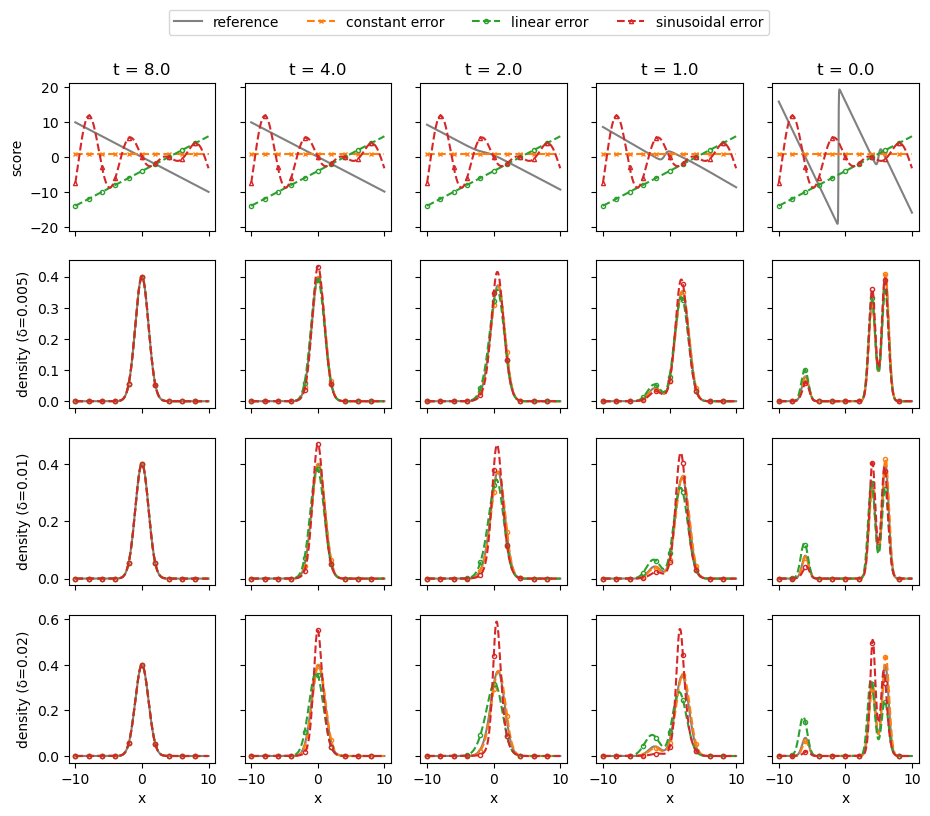

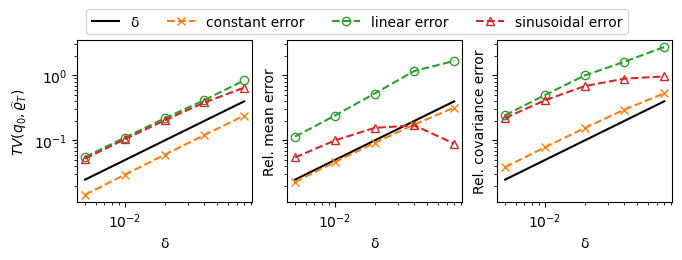

In [131]:
nrows, ncols = 4, 5
markers = ["x"; "o"; "^"]  
ts = [T; T/2; T/4; T/8; 0.0]

fig, ax = fig, ax = PyPlot.subplots(nrows = nrows, ncols=ncols, sharex=true, sharey="row", figsize=(10,8))
## plot score at different time
for i  = 1:ncols
    t = ts[i]
    δ = 1.0
    ∇logqt = compute_qt_score(x_w, x_mean, xx_cov, t, Array(reshape(xc, (Ne, 1))))
    ax[1, i].plot(xc, ∇logqt, "-", color = "grey", fillstyle="none", label="reference")
    for itype = 1:Ntype
        err = score_error(x_w, x_mean, xx_cov, δ, t, T,  Array(reshape(xc, (Ne, 1))); error_type = error_types[itype])
        ax[1, i].plot(xc, err, "--", marker = markers[itype], color = "C"*string(itype), fillstyle="none", markevery=100, markersize = 3, label = error_types[itype]*" error")
    end
    
    ax[1, i].title.set_text("t = "*string(t))
    ax[nrows, i].set_xlabel("x")
end
ax[1,1].set_ylabel("score")

    

for i  = 1:ncols
    # t = T - T*(i-1)/(ncols - 1)
    t = ts[i]
    qt = compute_qt(x_w, x_mean, xx_cov, t, Array(reshape(xc, (Ne, 1))))
    for j = 2:nrows
        ax[j, i].plot(xc, qt,   "-", color = "grey", fillstyle="none", label="reference")
        ax[j, 1].set_ylabel("density (δ=" * string(2.0^(j-3)/100)*")")
    end
end


for itype = 1:Ntype
    for iδ = 1:min(Nδ, nrows-1) 
        for i  = 1:ncols
            ir =  Int64((1 - ts[i]/T)*Nt) + 1
            ax[iδ+1, i].plot(xc, ρs[itype, iδ, ir,:], "--o", color = "C"*string(itype), fillstyle="none", markevery=100, markersize = 3)
        end
    end
end
handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,1.0),ncol=4)
fig.subplots_adjust(bottom=0.05,top=0.9,left=0.1,right=0.95,hspace=0.2)
fig.savefig("1D-pde-density.pdf")

fig, ax = PyPlot.subplots(nrows = 1, ncols=3, sharex=true, sharey="row", figsize=(7, 2.5))
for i = 1:3
    ax[i].loglog(δs, 5δs, "-", color = "black", fillstyle="none", label="δ")
    ax[i].set_xlabel("δ");
end
for itype = 1:Ntype
    ax[1].loglog(δs, TVes[itype, :], "--", marker = markers[itype], color = "C"*string(itype), fillstyle="none", label = error_types[itype]*" error")  
    ax[2].loglog(δs, rmeanes[itype, :], "--", marker = markers[itype], color = "C"*string(itype), fillstyle="none", label = error_types[itype]*" error")  
    ax[3].loglog(δs, rcoves[itype, :], "--", marker = markers[itype], color = "C"*string(itype), fillstyle="none", label = error_types[itype]*" error")  
end
handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,1.0),ncol=4)
ax[1].set_ylabel(L"TV(q_0,\widehat{\varrho}_T)")
ax[2].set_ylabel("Rel. mean error")
ax[3].set_ylabel("Rel. covariance error")
fig.subplots_adjust(bottom=0.2,top=0.85,left=0.1,right=0.95,hspace=0.2)
fig.savefig("1D-pde-error.pdf")



# ODE solver

In [132]:
function time_update(Y, t, dt, compute_v::Function)
    # dY/dt = v(Y)
    V = compute_v(t, Y)
    Y_h = Y + dt*V
                
    V_h = compute_v(t + dt, Y_h)         
    Y_n = Y + 0.5*dt*(V + V_h)
                
    return Y_n
end

function solve(T, Nt, Y0, compute_v::Function; ts = LinRange(0, T, Nt+1), save_ts_ind::Array{Int64,1} = Array(0:Nt+1)) 
    # save at time dt*save_ts_ind[1], dt*save_ts_ind[2] ...
    
    J, dim = size(Y0)
    Nt_save = length(save_ts_ind)
    Ys = zeros(Nt_save, J, dim)
    save_id = 1
    
    if save_ts_ind[save_id] == 0
        Ys[save_id, :, :] .= Y0
        save_id += 1
    end
    
    Y = copy(Y0)
    for i = 1:Nt
        dt = ts[i+1] - ts[i]
        t = ts[i]
        Y = time_update(Y , t, dt, compute_v)
        if save_id <= Nt_save && save_ts_ind[save_id] == i
            Ys[save_id, :, :] .= Y
            save_id += 1
        end
    end
            
    return Ys, ts[save_ts_ind.+1]
end



solve (generic function with 2 methods)

# 1D ODE solver
## Setup

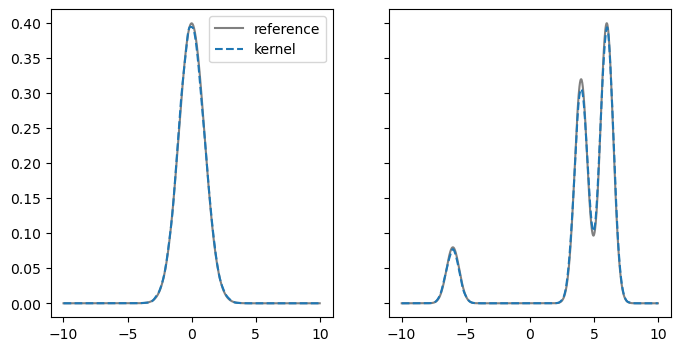

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0xfb8ca99f0>

In [133]:
Random.seed!(42)
Ny, dim = 40000, 1

T = 8.0
# Initial condition
Y0 = rand(Normal(0, 1), (Ny, dim))
 
# Visualize initial condition

cbandwidth(t) = (4/(Ny*(dim + 2)))^(1/(dim+4)) * (0.5*t/T + 1.0*(1 - t/T)) 

x_l, x_r, Ne = -10, 10, 1000
Δx = (x_r - x_l) / Ne
xx = LinRange(x_l, x_r, Ne + 1)
xc = (xx[1:Ne] + xx[2:Ne+1])/2.0
ρ0 = compute_qt([1.0;], [0.0;;], [[1.0;;]], 0.0, Array(reshape(xc, (Ne, 1))))        
kernel = kde(Y0[:,1], bandwidth=cbandwidth(0.0))
ρ̂0 = pdf(kernel, xc)
ρT = compute_qt(x_w, x_mean, xx_cov, 0.0, Array(reshape(xc, (Ne, 1))))        
YT = rand(MixtureModel(Normal[
   Normal(x_mean[1,1], sqrt(xx_cov[1][1,1])),
   Normal(x_mean[2,1], sqrt(xx_cov[2][1,1])),
   Normal(x_mean[3,1], sqrt(xx_cov[3][1,1]))], x_w), (Ny, dim))
    
kernel = kde(YT[:,1], bandwidth=cbandwidth(0.0))
ρ̂T = pdf(kernel, xc)
fig, ax = fig, ax = PyPlot.subplots(nrows = 1, ncols=2, sharex=true, sharey="row", figsize=(8,4))
ax[1].plot(xc, ρ0, "-", color="grey", label="reference")
ax[1].plot(xc, ρ̂0, "--", color="C0", label="kernel")
ax[1].legend()
ax[2].plot(xc, ρT, "-", color="grey", label="reference")
ax[2].plot(xc, ρ̂T, "--", color="C0", label="kernel")


## Compute

In [148]:
error_types = ["constant"; "linear"; "sinusoidal"]
δs = [0.005;0.01; 0.02; 0.04; 0.08]
Nts= [96;   64;   48;   32;   24]
# Nts= [64;   48;   32;   24;   16]
Ntype = length(error_types) 
Nδ = length(δs)

Nsave_ts_ind = 5
Ys = zeros(Ntype, Nδ, Nsave_ts_ind, Ny, dim) 
for itype = 1:Ntype
    for iδ = 1:Nδ 
        Nt = Nts[iδ]
        ts = LinRange(0, T, Nt+1)
        save_ts_ind = [0; div(Nt,2); 3*div(Nt,4); 7*div(Nt,8); Nt]
        compute_V(t, xx) = compute_U(t, xx) + score_error(x_w, x_mean, xx_cov, δs[iδ], t, T, (ndims(xx) == 1 ? Array(reshape(xx, (length(xx), 1))) : xx) ;error_type = error_types[itype])
        Ys[itype, iδ, :, :, :], _ = solve(T, Nt, Y0, compute_V; ts=ts, save_ts_ind=save_ts_ind) 
    end
end

In [149]:
q0 = compute_qt(x_w, x_mean, xx_cov, 0.0, Array(reshape(xc, (Ne, 1))))
TVes = zeros(Ntype, Nδ) 
rmeanes = zeros(Ntype, Nδ)   #relative mean error
rcoves = zeros(Ntype, Nδ)    #relative covariance error
GM_mean = x_w' * x_mean[:,1]
GM_cov = 0
for i = 1:length(x_w)
    GM_cov += x_w[i] * (xx_cov[i][1,1] + (x_mean[i,1] - GM_mean)^2)
end
for itype = 1:Ntype
    for iδ = 1:Nδ 
        YT = Ys[itype, iδ, end, :, :]
        kernel = kde(YT[:,1], bandwidth=cbandwidth(0.0))
        ρ̂T = pdf(kernel, xc)
        
        TVes[itype, iδ]   = sum(abs.(ρ̂T - q0)) / 2.0 * (xc[2] - xc[1])
        GM_mean_esti = sum(YT[:, 1])/Ny
        rmeanes[itype, iδ] = abs(GM_mean_esti - GM_mean) / GM_mean
        rcoves[itype, iδ]  = abs(sum((YT[:, 1] .- GM_mean_esti).^2)/Ny - GM_cov) / GM_cov

    end
end

## Visualize

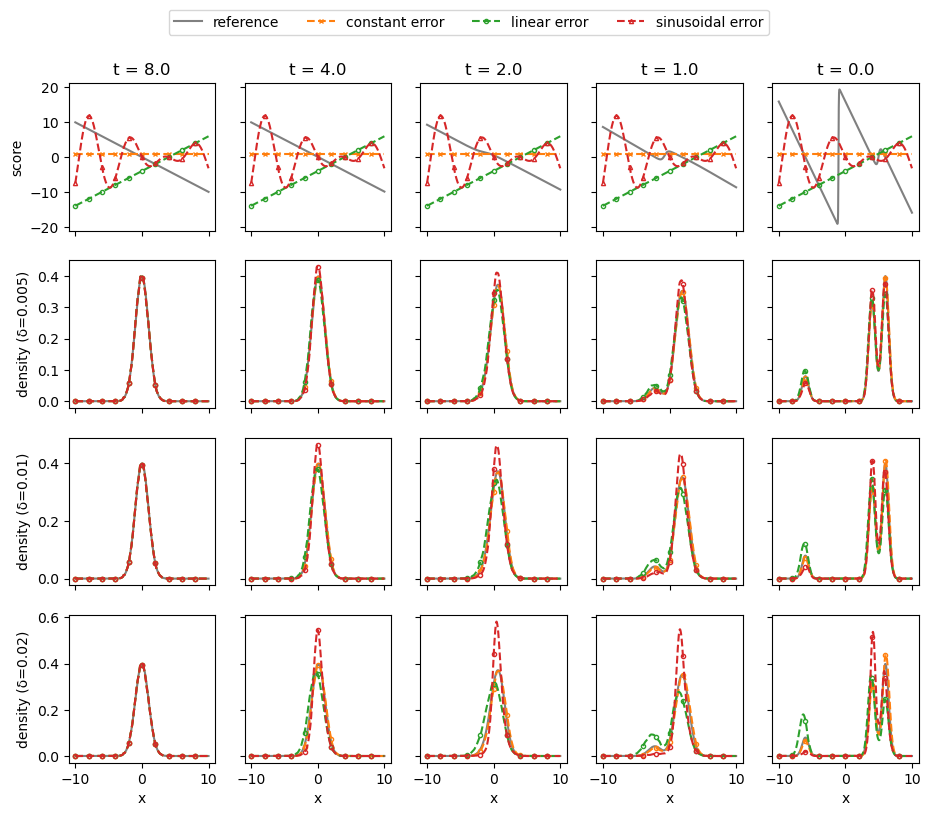

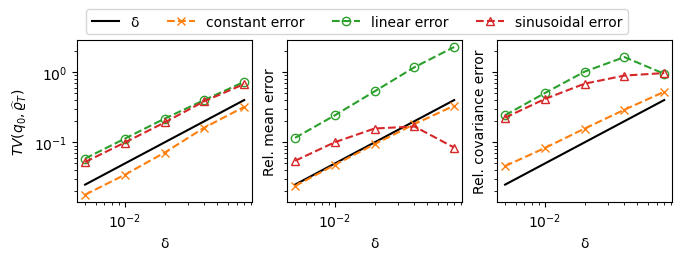

In [150]:
nrows, ncols = 4, 5
markers = ["x"; "o"; "^"]  
ts = [T; T/2; T/4; T/8; 0.0]
fig, ax = fig, ax = PyPlot.subplots(nrows = nrows, ncols=ncols, sharex=true, sharey="row", figsize=(10,8))

    
## plot score at different time
for i  = 1:ncols
    t = ts[i]
    δ = 1.0
    ∇logqt = compute_qt_score(x_w, x_mean, xx_cov, t, Array(reshape(xc, (Ne, 1))))
    ax[1, i].plot(xc, ∇logqt, "-", color = "grey", fillstyle="none", label="reference")
    for itype = 1:Ntype
        err = score_error(x_w, x_mean, xx_cov, δ, t, T,  Array(reshape(xc, (Ne, 1))); error_type = error_types[itype])
        ax[1, i].plot(xc, err, "--", marker=markers[itype], color = "C"*string(itype), fillstyle="none", markevery=100, markersize = 3, label = error_types[itype]*" error")
    end
    
    ax[1, i].title.set_text("t = "*string(t))
    ax[nrows, i].set_xlabel("x")
end
ax[1,1].set_ylabel("score")

    
## plot qt at different time
for i  = 1:ncols
    t = ts[i]
    qt = compute_qt(x_w, x_mean, xx_cov, t, Array(reshape(xc, (Ne, 1))))
    for j = 2:nrows
        ax[j, i].plot(xc, qt,   "-", color = "grey", fillstyle="none", label="reference")
        ax[j, 1].set_ylabel("density (δ=" * string(2.0^(j-3)/100)*")")
    end
end


for itype = 1:Ntype
    for iδ = 1:min(Nδ, nrows-1) 
        for i  = 1:ncols
            t = ts[i]
            kernel = kde(Ys[itype, iδ, i, :, 1], bandwidth=cbandwidth(t))
            ρ̂t = pdf(kernel, xc)
            ax[iδ+1, i].plot(xc, ρ̂t, "--o", color = "C"*string(itype), fillstyle="none", markevery=100, markersize = 3)
        end
    end
end
handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,1.0),ncol=4)
fig.subplots_adjust(bottom=0.05,top=0.9,left=0.1,right=0.95,hspace=0.2)
fig.savefig("1D-ode-density.pdf")

fig, ax = PyPlot.subplots(nrows = 1, ncols=3, sharex=true, sharey="row", figsize=(7, 2.5))
for i = 1:3
    ax[i].loglog(δs, 5δs, "-", color = "black", fillstyle="none", label="δ")
    ax[i].set_xlabel("δ");
end
for itype = 1:Ntype
    ax[1].loglog(δs, TVes[itype, :], "--", marker=markers[itype], color = "C"*string(itype), fillstyle="none", label = error_types[itype]*" error")  
    ax[2].loglog(δs, rmeanes[itype, :], "--", marker=markers[itype], color = "C"*string(itype), fillstyle="none", label = error_types[itype]*" error")  
    ax[3].loglog(δs, rcoves[itype, :], "--", marker=markers[itype], color = "C"*string(itype), fillstyle="none", label = error_types[itype]*" error")  
end
handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,1.0),ncol=4)
ax[1].set_ylabel(L"TV(q_0,\widehat{\varrho}_T)")
ax[2].set_ylabel("Rel. mean error")
ax[3].set_ylabel("Rel. covariance error")
fig.subplots_adjust(bottom=0.2,top=0.85,left=0.1,right=0.95,hspace=0.2)
fig.savefig("1D-ode-error.pdf")



# High dimensional ODE solver
## Setup
We follow the setup in Albergo, Michael S., Nicholas M. Boffi, and Eric Vanden-Eijnden. "Stochastic interpolants: A unifying framework for flows and diffusions." arXiv preprint arXiv:2303.08797 (2023).

[ Info: ("reference x_w = ", [0.19194250492303952, 0.21609780841596313, 0.3280755236320224, 0.07030341547263623, 0.19358074755633872])
[ Info: ("ρT vs N(0,1)  TV: ", 0.00019346970816728646, " mean: ", 0.0056856363565632746, " cov: ", 3.977247717490061e-6)
[ Info: ("Y vs N(0,1)  TV: ", 0.007546115820321633, " mean: ", 0.060558328504030014, " cov: ", 0.05697782335734813)
[ Info: ("sample errors", " TV: ", 0.01227515879442219, " mean: ", 0.015415949464008101, " cov: ", 0.017726416630772946)


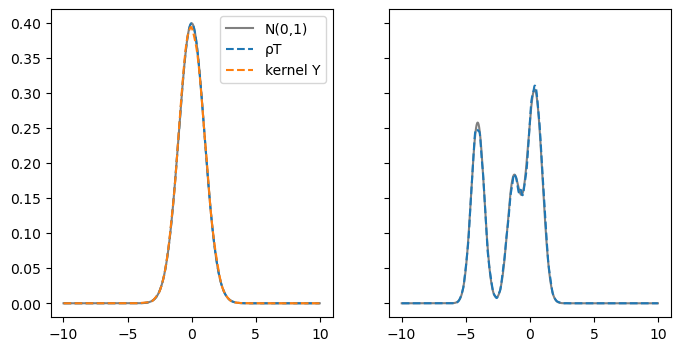

In [206]:
Random.seed!(123)

Ny, dim_high = 40000, 128
N_modes = 5
x_w =  rand(Uniform(0,1), N_modes) 
x_w = x_w/sum(x_w)
@info "reference x_w = ", x_w

x_mean_high = 3.0*rand(Normal(0, 1), (N_modes, dim_high))
COV_DIAG = false

xx_cov_high = []
function extract_submatrix(xx_cov_high, dim, cov_diag)
    xx_cov = (cov_diag ? [Diagonal(diag(xx_cov_high[i])[1:dim]) for i = 1:length(xx_cov_high)] : [xx_cov_high[i][1:dim,1:dim] for i = 1:length(xx_cov_high)])
    return xx_cov
end
for i = 1:N_modes
    if COV_DIAG
        W = rand(Normal(0, 1), (dim_high))
        push!(xx_cov_high, 0.25*(Diagonal(W.*W) + I)/2.0)
    else
        W = rand(Normal(0, 1), (dim_high, dim_high))
        push!(xx_cov_high, 0.25*(W'*W/dim_high + I)/2.0)
    end
end



T = 8.0
Y0_high = rand(Normal(0, 1), (Ny, dim_high))
 

cbandwidth(t) = (4/(Ny*(1 + 2)))^(1/(1+4)) * (0.5*t/T + 1.0*(1 - t/T)) 

x_l, x_r, Ne = -10, 10, 1000
Δx = (x_r - x_l) / Ne
xx = LinRange(x_l, x_r, Ne + 1)
xc = (xx[1:Ne] + xx[2:Ne+1])/2.0


dim, x_mean, xx_cov, Y0 = dim_high, x_mean_high, xx_cov_high, Y0_high
# Visualize/validate initial condition
fig, ax = fig, ax = PyPlot.subplots(nrows = 1, ncols=2, sharex=true, sharey="row", figsize=(8,4))
ρ0 = compute_qt([1.0;], [0.0;;], [[1.0;;]], 0.0, Array(reshape(xc, (Ne, 1))))        
ρT = compute_qt(x_w, x_mean[:, 1:1], [xx_cov[i][1:1,1:1] for i = 1:N_modes], T, Array(reshape(xc, (Ne, 1))))        
x_mean_T, xx_cov_T = compute_mt_covt(x_w, x_mean, xx_cov, T) 
GM_mean_T = x_mean_T' * x_w 
GM_cov_T = zeros(dim, dim)
for i = 1:N_modes
    GM_cov_T += x_w[i] * (xx_cov_T[i] + (x_mean_T[i,:] - GM_mean_T)*(x_mean_T[i,:] - GM_mean_T)')
end
kernel = kde(Y0[:,1], bandwidth=cbandwidth(0.0))
ρ̂0 = pdf(kernel, xc)
@info "ρT vs N(0,1)  TV: ", sum(abs.(ρ0 - ρT)) / 2.0 * (xc[2] - xc[1]) , " mean: ", norm(GM_mean_T),  " cov: ", norm(GM_cov_T - I)/norm(Diagonal(ones(dim)))


GM_mean_esti = sum(Y0, dims=1)[:]/Ny
rcove   = norm((Y0 - ones(Ny)*GM_mean_esti')'*(Y0 - ones(Ny)*GM_mean_esti')/Ny - I) / norm(Diagonal(ones(dim)))
@info "Y vs N(0,1)  TV: ", sum(abs.(ρ0 - ρ̂0)) / 2.0 * (xc[2] - xc[1]) , " mean: ", norm(GM_mean_esti),  " cov: ", rcove


ax[1].plot(xc, ρ0, "-", color="grey", label="N(0,1)")
ax[1].plot(xc, ρT, "--", color="C0", label="ρT")
ax[1].plot(xc, ρ̂0, "--", color="C1", label="kernel Y")
ax[1].legend()

# test on final solution
ρT = compute_qt(x_w, x_mean[:, 1:1], [xx_cov[i][1:1,1:1] for i = 1:N_modes], 0.0, Array(reshape(xc, (Ne, 1))))        
YT = rand(MixtureModel(MvNormal[
   MvNormal(x_mean[1,:],  xx_cov[1]),
   MvNormal(x_mean[2,:],  xx_cov[2]),
   MvNormal(x_mean[3,:],  xx_cov[3]),
   MvNormal(x_mean[4,:],  xx_cov[4]),
   MvNormal(x_mean[5,:],  xx_cov[5])], x_w), (Ny))

kernel = kde(YT[1,:], bandwidth=cbandwidth(T))
ρ̂T = pdf(kernel, xc)
ax[2].plot(xc, ρT, "-", color="grey", label="reference")
ax[2].plot(xc, ρ̂T, "--", color="C0", label="kernel")


GM_mean = x_mean' * x_w 
GM_cov = zeros(dim, dim)
for i = 1:N_modes
    GM_cov += x_w[i] * (xx_cov[i] + (x_mean[i,:] - GM_mean)*(x_mean[i,:] - GM_mean)')
end
kernel = kde(YT[1,:], bandwidth=cbandwidth(T)) #project to the first component
ρ̂T = pdf(kernel, xc)
TVe    = sum(abs.(ρ̂T - ρT)) / 2.0 * (xc[2] - xc[1])
GM_mean_esti = sum(YT, dims=2)[:]/Ny
rmeane  = norm(GM_mean_esti - GM_mean) / norm(GM_mean)
rcove   = norm((YT' - ones(Ny)*GM_mean_esti')'*(YT' - ones(Ny)*GM_mean_esti')/Ny - GM_cov) / norm(GM_cov)
@info "sample errors",  " TV: ", TVe, " mean: ", rmeane,  " cov: ", rcove


## Compute

In [207]:
dims = [8; 32; 128]
error_types = ["constant"; "linear"; "sinusoidal"]
δs = [0.005; 0.01; 0.02; 0.04; 0.08]
Nts= [96;   64;   48;   32;   24]
Ntype = length(error_types) 
Nδ = length(δs)
Ndim = length(dims)
Nsave_ts_ind = 5
Ys = zeros(Ndim, Ntype, Nδ, Nsave_ts_ind, Ny, dim_high) 
for idim = 1:Ndim
    dim = dims[idim]
    x_mean = x_mean_high[:, 1:dim]
    xx_cov = extract_submatrix(xx_cov_high, dim, COV_DIAG)
    Y0 = Y0_high[:, 1:dim]
    for itype = 1:Ntype
        for iδ = 1:Nδ 
            @info dim, error_types[itype], δs[iδ]
            Nt = Nts[iδ]
            ts = LinRange(0, T, Nt+1)
            save_ts_ind = [0; div(Nt,2); 3*div(Nt,4); 7*div(Nt,8); Nt]
            compute_U(t, xx) = compute_U_GM(x_w, x_mean, xx_cov, t, T, (ndims(xx) == 1 ? Array(reshape(xx, (length(xx), 1))) : xx) )
            compute_V(t, xx) = compute_U(t, xx) + score_error(x_w, x_mean, xx_cov, δs[iδ], t, T, (ndims(xx) == 1 ? Array(reshape(xx, (length(xx), 1))) : xx) ;error_type = error_types[itype])
            Ys[idim, itype, iδ, :, :, 1:dim], _ = solve(T, Nt, Y0, compute_V; ts=ts, save_ts_ind=save_ts_ind) 
        end
    end
end



[ Info: (8, "constant", 0.005)
[ Info: (8, "constant", 0.01)
[ Info: (8, "constant", 0.02)
[ Info: (8, "constant", 0.04)
[ Info: (8, "constant", 0.08)
[ Info: (8, "linear", 0.005)
[ Info: (8, "linear", 0.01)
[ Info: (8, "linear", 0.02)
[ Info: (8, "linear", 0.04)
[ Info: (8, "linear", 0.08)
[ Info: (8, "sinusoidal", 0.005)
[ Info: (8, "sinusoidal", 0.01)
[ Info: (8, "sinusoidal", 0.02)
[ Info: (8, "sinusoidal", 0.04)
[ Info: (8, "sinusoidal", 0.08)
[ Info: (32, "constant", 0.005)
[ Info: (32, "constant", 0.01)
[ Info: (32, "constant", 0.02)
[ Info: (32, "constant", 0.04)
[ Info: (32, "constant", 0.08)
[ Info: (32, "linear", 0.005)
[ Info: (32, "linear", 0.01)
[ Info: (32, "linear", 0.02)
[ Info: (32, "linear", 0.04)
[ Info: (32, "linear", 0.08)
[ Info: (32, "sinusoidal", 0.005)
[ Info: (32, "sinusoidal", 0.01)
[ Info: (32, "sinusoidal", 0.02)
[ Info: (32, "sinusoidal", 0.04)
[ Info: (32, "sinusoidal", 0.08)
[ Info: (128, "constant", 0.005)
[ Info: (128, "constant", 0.01)
[ Info: (128, 

In [211]:
# marginal distribution
q0 = compute_qt(x_w, x_mean[:, 1:1], [xx_cov[i][1:1,1:1] for i = 1:N_modes], 0.0, Array(reshape(xc, (Ne, 1))))        
TVes = zeros(Ndim, Ntype, Nδ) 
rmeanes = zeros(Ndim, Ntype, Nδ)   #relative mean error
rcoves = zeros(Ndim, Ntype, Nδ)    #relative covariance error

for idim = 1:Ndim
    dim = dims[idim]
    x_mean = x_mean_high[:, 1:dim]
    xx_cov = extract_submatrix(xx_cov_high, dim, COV_DIAG)
    Y0 = Y0_high[:, 1:dim]

    GM_mean = x_mean' * x_w 
    GM_cov = zeros(dim, dim)
    for i = 1:N_modes
        GM_cov += x_w[i] * (xx_cov[i] + (x_mean[i,:] - GM_mean)*(x_mean[i,:] - GM_mean)')
    end

    for itype = 1:Ntype
        for iδ = 1:Nδ 
            YT = Ys[idim, itype, iδ, end, :, 1:dim]
            kernel = kde(YT[:,1], bandwidth=cbandwidth(T)) #project to the first component
            ρ̂T = pdf(kernel, xc)
            TVes[idim, itype, iδ]   = sum(abs.(ρ̂T - q0)) / 2.0 * (xc[2] - xc[1])
            GM_mean_esti = sum(YT, dims=1)[:]/Ny
            rmeanes[idim, itype, iδ] = norm(GM_mean_esti - GM_mean) / norm(GM_mean)
            rcoves[idim, itype, iδ]  = norm((YT - ones(Ny)*GM_mean_esti')'*(YT - ones(Ny)*GM_mean_esti')/Ny - GM_cov) / norm(GM_cov)

            @info dim, error_types[itype], δs[iδ],  "mean: ",  rmeanes[idim, itype, iδ], " TV: ", TVes[idim, itype, iδ], " cov: ", rcoves[idim, itype, iδ] 
        end
    end
end

[ Info: (8, "constant", 0.005, "mean: ", 0.05336390028284229, " TV: ", 0.023698030397724817, " cov: ", 0.022316961893607656)
[ Info: (8, "constant", 0.01, "mean: ", 0.1003193028705695, " TV: ", 0.04099772485714148, " cov: ", 0.04172312652636911)
[ Info: (8, "constant", 0.02, "mean: ", 0.19616407740877567, " TV: ", 0.079216183715549, " cov: ", 0.0820004589403864)
[ Info: (8, "constant", 0.04, "mean: ", 0.3764533497695408, " TV: ", 0.15615781167389622, " cov: ", 0.16475608268588748)
[ Info: (8, "constant", 0.08, "mean: ", 0.6972845486390246, " TV: ", 0.2972109355668206, " cov: ", 0.3317905085304966)
[ Info: (8, "linear", 0.005, "mean: ", 0.03081024405881274, " TV: ", 0.011258293589506205, " cov: ", 0.027733230559106346)
[ Info: (8, "linear", 0.01, "mean: ", 0.061807125322170656, " TV: ", 0.013531458412120915, " cov: ", 0.05498157675086389)
[ Info: (8, "linear", 0.02, "mean: ", 0.1260714171091619, " TV: ", 0.01852584502189711, " cov: ", 0.1130413800890152)
[ Info: (8, "linear", 0.04, "mea

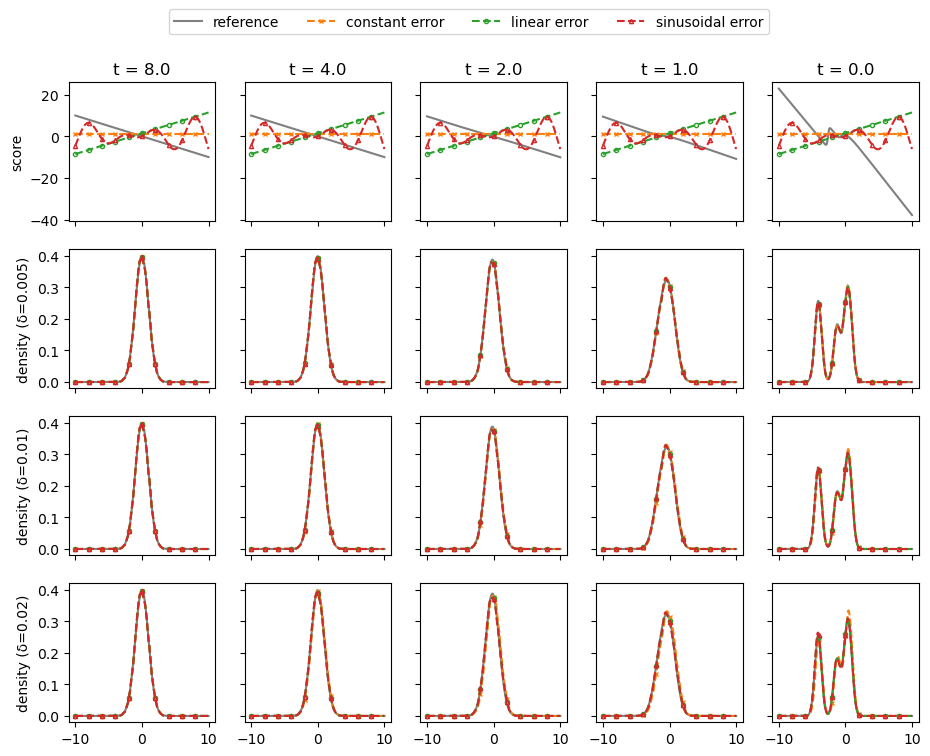

In [212]:
# plot marginal for 128 dimensional problem
nrows, ncols = 4, 5
markers = ["x"; "o"; "^"]  
ts = [T; T/2; T/4; T/8; 0.0]
idim = 3 
dim = dims[idim]
x_mean = x_mean_high[:, 1:dim]
xx_cov = extract_submatrix(xx_cov_high, dim, COV_DIAG)
Y0 = Y0_high[:, 1:dim]


fig, ax = fig, ax = PyPlot.subplots(nrows = nrows, ncols=ncols, sharex=true, sharey="row", figsize=(10,8))
## plot marginal score at different time
for i  = 1:ncols
    t = ts[i]
    δ = 1.0
    ∇logqt = compute_qt_score(x_w, x_mean[:,1:1], [xx_cov[i][1:1,1:1] for i = 1:N_modes], t, Array(reshape(xc, (Ne, 1))))
    ax[1, i].plot(xc, ∇logqt, "-", color = "grey", fillstyle="none", label="reference")
    for itype = 1:Ntype
        err = score_error(x_w, x_mean[:,1:1], [xx_cov[i][1:1,1:1] for i = 1:N_modes], δ, t, T,  Array(reshape(xc, (Ne, 1))); error_type = error_types[itype])
        ax[1, i].plot(xc, err, "--", marker=markers[itype], color = "C"*string(itype), fillstyle="none", markevery=100, markersize = 3, label = error_types[itype]*" error")
    end
    
    ax[1, i].title.set_text("t = "*string(t))
end
ax[1,1].set_ylabel("score")

    
## plot marginal qt at different time
for i  = 1:ncols
    t = ts[i]
    qt = compute_qt(x_w, x_mean[:,1:1], [xx_cov[i][1:1,1:1] for i = 1:N_modes], t, Array(reshape(xc, (Ne, 1))))
    for j = 2:nrows
        ax[j, i].plot(xc, qt,   "-", color = "grey", fillstyle="none", label="reference")
        ax[j, 1].set_ylabel("density (δ=" * string(2.0^(j-3)/100)*")")
    end
end

# marginal 
for itype = 1:Ntype
    for iδ = 1:min(Nδ, nrows-1) 
        for i  = 1:ncols
            t = ts[i]
            kernel = kde(Ys[idim, itype, iδ, i, :, 1], bandwidth=cbandwidth(t))
            ρ̂t = pdf(kernel, xc)
            ax[iδ+1, i].plot(xc, ρ̂t, "--", marker=markers[itype], color = "C"*string(itype), fillstyle="none", markevery=100, markersize = 3)
        end
    end
end
handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,1.0),ncol=4)
fig.subplots_adjust(bottom=0.1,top=0.90,left=0.1,right=0.95,hspace=0.2)
fig.savefig("high-D-ode-density.pdf")


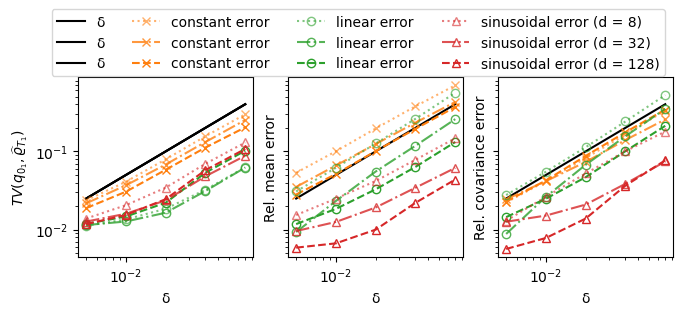

In [215]:
fig, ax = PyPlot.subplots(nrows = 1, ncols=3, sharex=true, sharey="row", figsize=(7, 3.0))
for i = 1:3
    ax[i].loglog(δs, 5δs, "-", color = "black", fillstyle="none", label="δ")
    ax[i].set_xlabel("δ");
end
ax[1].loglog(δs, 5δs, "-", color = "black", fillstyle="none", label="δ")
ax[1].loglog(δs, 5δs, "-", color = "black", fillstyle="none", label="δ")

linestyles = ["dotted"; "dashdot"; "--"]
alphas =[0.6; 0.8; 1.0]
for itype = 1:Ntype
    for idim = 1:Ndim
        label = ( itype == Ntype ? error_types[itype]*" error (d = "* string(dims[idim]) * ")" : error_types[itype]*" error" )
        ax[1].loglog(δs, TVes[idim, itype, :], linestyle=linestyles[idim], marker=markers[itype], color = "C"*string(itype), alpha =alphas[idim], fillstyle="none", label = label)  
        ax[2].loglog(δs, rmeanes[idim, itype, :], linestyle=linestyles[idim], marker=markers[itype], color = "C"*string(itype), alpha =alphas[idim], fillstyle="none", label = label)  
        ax[3].loglog(δs, rcoves[idim, itype, :], linestyle=linestyles[idim], marker=markers[itype], color = "C"*string(itype), alpha =alphas[idim], fillstyle="none", label = label)  
    end
end
handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,1.0),ncols=4)
ax[1].set_ylabel(L"TV(q_{0_1},\widehat{\varrho}_{T_1})")
ax[2].set_ylabel("Rel. mean error")
ax[3].set_ylabel("Rel. covariance error")
fig.subplots_adjust(bottom=0.15,top=0.75,left=0.1,right=0.95,hspace=0.2)
fig.savefig("high-D-ode-error.pdf")
